In [1]:
!pip install transformers

In [2]:
!pip install transformers[torch] -U  # Ensures all related dependencies are installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 20.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

In [3]:
!pip install accelerate -U        # Ensures accelerate is installed and updated

In [4]:
import transformers
import accelerate
print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)

Transformers version: 4.40.1
Accelerate version: 0.29.3


In [5]:
import torch
import os
import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from huggingface_hub import notebook_login, HfApi, HfFolder
from torch.utils.data import DataLoader, Dataset

# Ensure token is available or prompt for login
token = os.getenv('HF_TOKEN')
if token is None:
    print("Please set the HF_TOKEN environment variable.")
    notebook_login()
else:
    # Authenticate session
    from huggingface_hub import HfFolder
    HfFolder.save_token(token)

# Initialize Hugging Face API client and check authentication
api = HfApi()
try:
    user_models = api.list_models(use_auth_token=token)
    model_list = list(user_models)  # Safely handle the generator
    print("Authentication successful! Number of accessible models: ", len(model_list))
except Exception as e:
    print("Failed to authenticate or retrieve models:", str(e))


Please set the HF_TOKEN environment variable.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Authentication successful! Number of accessible models:  618171


In [6]:
# Load the pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set the EOS token as the padding token for models that don't have it by default

model = GPT2LMHeadModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [9]:
# Load and preprocess the dataset
df = pd.read_csv('ff7-simplified.csv')
df['formatted_text'] = df['Character'] + ": " + df['Dialogue']  # Format text by combining character names and their dialogue

In [11]:
# Tokenize and encode the data for GPT-2
training_data = tokenizer(df['formatted_text'].tolist(), add_special_tokens=True, return_tensors='pt', max_length=512, padding="max_length", truncation=True)

In [10]:
class GPTCustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        # Ensure each tensor is detached from the graph and cloned to avoid in-place modifications
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        # Setting input_ids as labels for the model to compute loss
        item['labels'] = item['input_ids'].clone()
        return item


In [12]:
# Instantiate the dataset object using the tokenized data
dataset = GPTCustomDataset(training_data)

In [13]:
eval_loader = DataLoader(dataset, batch_size=2)

In [14]:
def calculate_perplexity(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in dataloader:
            # Move all tensors in the batch to the same device as the model
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(input_ids=inputs['input_ids'], labels=inputs['labels'])
            logits = outputs.logits
            # Calculate the cross-entropy loss between the predictions and the labels
            loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), inputs['labels'].view(-1))
            total_loss += loss.item()
    # Calculate the average loss across all batches and exponentiate for perplexity
    average_loss = total_loss / len(dataloader)
    perplexity = torch.exp(torch.tensor(average_loss))
    return perplexity


In [15]:
# Setup the training arguments
training_args = TrainingArguments(
    output_dir='./results',               # Directory for saving model checkpoints and logs
    num_train_epochs=4,                   # Number of epochs to train for
    per_device_train_batch_size=2,        # Batch size per device (adjust based on your GPU memory)
    warmup_steps=500,                     # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # Weight decay to apply
    logging_dir='./logs',                 # Directory to save logs
    logging_steps=10                      # Log every 10 steps
)

In [16]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

In [ ]:
# Start training the model
trainer.train()

Step,Training Loss
10,0.139100
20,0.110800
30,0.117500
40,0.099600
50,0.095800
60,0.118700
70,0.127700
80,0.113900


In [ ]:
#model.to('cuda:0')  # Moves the model to the GPU
#for batch in eval_loader:
#    input_ids = batch['input_ids'].to('cuda:0')  # Move input data to GPU
#    labels = batch['labels'].to('cuda:0')  # Move labels to GPU
#    outputs = model(input_ids, labels=labels)

In [17]:
import matplotlib.pyplot as plt

print("Starting perplexity calculation...")
def calculate_perplexity(model, dataloader):
    print("Model set to eval mode.")
    model.eval()
    total_loss = 0
    print("Entering the loop over DataLoader...")
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            print(f"Processing batch {i+1}/{len(dataloader)}")
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(input_ids=inputs['input_ids'], labels=inputs['labels'])
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), inputs['labels'].view(-1))
            total_loss += loss.item()
        average_loss = total_loss / len(dataloader)
        perplexity = torch.exp(torch.tensor(average_loss))
        print(f"Calculated perplexity: {perplexity}")
        return perplexity

Starting perplexity calculation...


Model set to eval mode.
Entering the loop over DataLoader...
Processing batch 1/2339
Processing batch 2/2339
Processing batch 3/2339
Processing batch 4/2339
Processing batch 5/2339
Processing batch 6/2339
Processing batch 7/2339
Processing batch 8/2339
Processing batch 9/2339
Processing batch 10/2339
Processing batch 11/2339
Processing batch 12/2339
Processing batch 13/2339
Processing batch 14/2339
Processing batch 15/2339
Processing batch 16/2339
Processing batch 17/2339
Processing batch 18/2339
Processing batch 19/2339
Processing batch 20/2339
Processing batch 21/2339
Processing batch 22/2339
Processing batch 23/2339
Processing batch 24/2339
Processing batch 25/2339
Processing batch 26/2339
Processing batch 27/2339
Processing batch 28/2339
Processing batch 29/2339
Processing batch 30/2339
Processing batch 31/2339
Processing batch 32/2339
Processing batch 33/2339
Processing batch 34/2339
Processing batch 35/2339
Processing batch 36/2339
Processing batch 37/2339
Processing batch 38/233

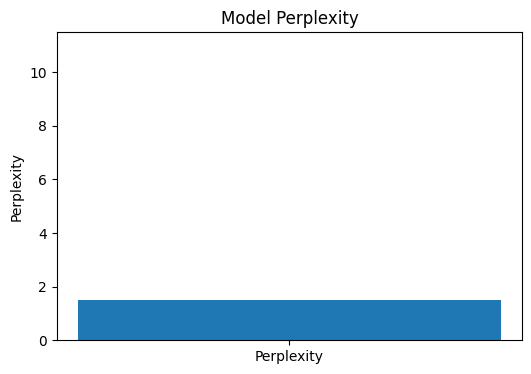

In [19]:
# After training, calculate perplexity
perplexity = calculate_perplexity(model, eval_loader)

plt.figure(figsize=(6, 4))
plt.bar(['Perplexity'], [perplexity.item()])  # Perplexity value as a bar chart
plt.ylabel('Perplexity')
plt.title('Model Perplexity')
plt.ylim(top=perplexity.item() + 10)  # Adjust ylim according to the perplexity value for better visualization
plt.show()